Students:

- Zhe HUANG
- ...
- ...

# Deep Learning - Lab Exercise 2

**WARNING:** you must have finished the first exercise before this one as you will re-use parts of the code.

In the first lab exercise, we built a simple linear classifier.
Although it can give reasonable results on the MNIST dataset (~92.5% of accuracy), deeper neural networks can achieve more the 99% accuracy.
However, it can quickly become really impracical to explicitly code forward and backward passes.
Hence, it is useful to rely on an auto-diff library where we specify the forward pass once, and the backward pass is automatically deduced from the computational graph structure.

In this lab exercise, we will build a small and simple auto-diff lib that mimics the autograd mechanism from Pytorch (of course, we will simplify a lot!)


In [3]:
# import libs that we will use
import os
import numpy as np
import matplotlib.pyplot as plt
import math

# To load the data we will use the script of Gaetan Marceau Caron
# You can download it from the course webiste and move it to the same directory that contains this ipynb file
import dataset_loader

%matplotlib inline

In [4]:
np.random.seed(6942042)

# Data

In [5]:
mnist_path = "./mnist.pkl.gz"

In [7]:
# load the 3 splits
train_data, dev_data, test_data = dataset_loader.load_mnist(mnist_path)

label: 3


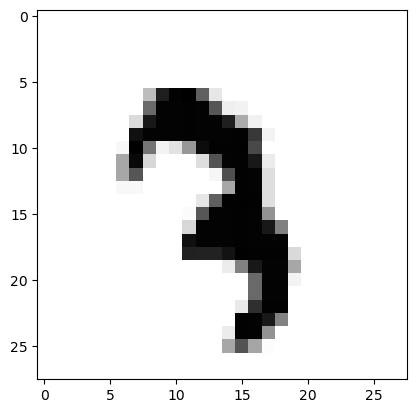

In [8]:
index = 900
label = train_data[1][index]
picture = train_data[0][index]

print("label: %i" % label)
plt.imshow(picture.reshape(28,28), cmap='Greys')

# Computation nodes

Instead of directly manipulating numpy arrays, we will manipulate abstraction that contains:
- a value (i.e. a numpy array)
- a bool indicating if we wish to compute the gradient with respect to the value
- the gradient with respect to the value
- the operation to call during backpropagation

There will be two kind of nodes:
- Tensor: a generic computation node
- Parameter: a computation node that is used to store parameters of the network. Parameters are always leaf nodes, i.e. they cannot be build from other computation nodes.

Our implementation of the backward pass will be really simple and incorrect in the general case (i.e. won't work with computation graph with loops).
We will just apply the derivative function for a given tensor and then call the ones of its antecedents, recursively.
This simple algorithm is good enough for this exercise.

Note that a real implementation of backprop will store temporary values during forward that can be used during backward to improve computation speed. We do not do that here.

In [9]:
class Tensor:
    def __init__(self, data, require_grad=False):
        # test type of data: should be np array
        if isinstance(data, float) or isinstance(data, int):
            data = np.array([data,])
        if type(data) != np.ndarray:
            raise RuntimeError("Input should be a numpy array")

        # store data for this tensor
        self.data = data
        self.require_grad = require_grad
        
        # this values should be set to enable autograd!
        self.gradient = None
        self.d = None
        self.backptr = None
        
    def zero_grad(self):
        """
        Set the gradient of thie tensor to 0
        """
        if self.require_grad:
            self.gradient = np.zeros_like(self.data)
            
    def accumulate_gradient(self, gradient):
        """
        Accumulte gradient for this tensor
        """
        if gradient.shape != self.data.shape:
            raise RuntimeError("Invalid gradient dimension")

        if self.gradient is None:
            self.gradient = np.copy(gradient)
        else:
            self.gradient += gradient
            
    def backward(self, g=None):
        """
        The backward pass!
        If g != None, then g is the gradient for the current node.
        i.e. g will be != None only for the loss output.
        
        You should call the function stored in self.d with correct arguments,
        and then recursively call the backward methods of tensors in the backptr list if:
        1. they require a gradient
        2. they are of type Tensor: check with isinstance(o, Tensor)
        """
        if not self.require_grad:  # stop right now if this node does not require a gradient
            return
        
        if g is not None:
            if isinstance(g, float):
                g = np.array([g])
            if type(g) != np.ndarray:
                raise RuntimeError("Gradient should be a numpy array")
            if g.shape != self.data.shape:
                raise RuntimeError("Gradient of different size than the value!")
                
            self.gradient = g
        else:
            g = self.gradient

        self.d(self.backptr, g)
        
        for node in self.backptr:
            if not isinstance(node, Parameter) and node.require_grad:
                if isinstance(node, Tensor):
                    node.backward()
                else:
                    raise RuntimeError("Node should be a Tensor")

    
class Parameter(Tensor):
    """
    This class will be used to store parameters of the network only!
    """
    def __init__(self, data, name="unamed"):
        super().__init__(data, require_grad=True)
        self.name = name
        
    def backward(self):
        raise RuntimeError("You cannot backprop from a Parameter node")

# Functions

Functions manipulate tensors and build the required information for autograd.
A function returns a Tensor that should have require_grad = True if at least of the arguments require a gradient.

In [10]:
def any_require_grad(l):
    """
    Input:
    - l: an iterable (e.g. a list)
    Ouput:
    - True if any tensor in the input requires a gradient
    """
    return any(t.require_grad for t in l)

In [11]:
# Here is an exemple with the ReLU
def relu(x):
    """
    Compute the ReLU of Tensor x
    Parameters:
    - x: a Tensor
    Returns:
    - a Tensor with the same shape as x    
    """
    v = np.maximum(0, x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_relu
    output.backptr = [x]
    
    return output

def backward_relu(backptr, g):
    """
    The backward pass for the ReLU
    Parameters:
    - backptr: a list of tensors that are the inputs of the ReLU
    - g: the gradient for the output of the ReLU
    """    
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (x.data > 0))

In [12]:
def tanh(x):
    """
    Compute the tanh of Tensor x
    Parameters:
    - x: a Tensor
    Returns:
    - a Tensor with the same shape as x    
    """
    v = np.tanh(x.data)
    
    output = Tensor(v, require_grad=x.require_grad)
    output.d = backward_tanh
    output.backptr = [x]
    
    return output

def backward_tanh(backptr, g):
    """
    The backward pass for the tanh
    Parameters:
    - backptr: a list of tensors that are the inputs of the tanh
    - g: the gradient for the output of the tanh
    """    
    x, = backptr
    
    # the gradient is accumulated in the arguments only if required
    if x.require_grad:
        x.accumulate_gradient(g * (1 - np.tanh(x.data)**2))

Next, we implement the affine transform operation.
You can reuse the code from the first lab exercise, with one major difference: you have to compute the gradient with respect to x too!

In [13]:
def affine_transform(W, b, x):
    """
    Compute the affine_transform of Tensor x
    Parameters:
    - W: a Parameter
    - b: a Parameter
    - x: a Tensor
    Returns:
    - a Tensor with the same shape as x    
    """
    v = x.data @ W.data.T + b.data
    
    output = Tensor(v, require_grad=any_require_grad([W, b, x]))
    output.d = backward_affine_transform
    output.backptr = [W, b, x]
    return output

def backward_affine_transform(backptr, g):
    """
    The backward pass for the affine_transform
    Parameters:
    - backptr: a list of tensors that are the inputs of the affine_transform
    - g: the gradient for the output of the affine_transform
    """
    W, b, x = backptr
    
    # the gradient is accumulated in the arguments only if required
    if W.require_grad:
        W.accumulate_gradient(g.reshape(-1,1) @ x.data.reshape(1,-1))
    if b.require_grad:
        b.accumulate_gradient(g)
    if isinstance(x, Tensor) and x.require_grad:
        x.accumulate_gradient(g @ W.data)

In [14]:
# we use an underscore because this function does not manipulate tensors:
# it is exactly the same as in the previous exercise
def _softmax(x):
    b = np.max(x)
    y = np.exp(x - b)
    return y / np.sum(y)

def nll(x, gold):
    """
    Compute the nll of Tensor x
    Parameters:
    - x: a Tensor
    - gold: a Tensor(but a single value)
    Returns:
    - a Tensor with the same shape as x    
    """
    v = -x.data[gold.data[0]] + np.log(np.sum(np.exp(x.data)))
    
    output = Tensor(v, require_grad=any_require_grad([x, gold]))
    output.d = backward_nll
    output.backptr = [x, gold]
    return output

def backward_nll(backptr, g):
    """
    The backward pass for the nll
    Parameters:
    - backptr: a list of tensors that are the inputs of the nll
    - g: the gradient for the output of the nll
    """
    x, gold = backptr
    
    y = _softmax(x.data)
    y[gold.data] -= 1
    if x.require_grad:
        x.accumulate_gradient(g * y)

# Module

Neural networks or parts of neural networks will be stored in Modules.
They implement method to retrieve all parameters of the network and subnetwork.

In [15]:
class Module:
    def __init__(self):
        raise NotImplemented("")
        
    def parameters(self):
        ret = []
        for name in dir(self):
            o = self.__getattribute__(name)

            if type(o) is Parameter:
                ret.append(o)
            if isinstance(o, Module) or isinstance(o, ModuleList):
                ret.extend(o.parameters())
        return ret

# if you want to store a list of Parameters or Module,
# you must store them in a ModuleList instead of a python list,
# in order to collect the parameters correctly
class ModuleList(list):
    def parameters(self):
        ret = []
        for m in self:
            if type(m) is Parameter:
                ret.append(m)
            elif isinstance(m, Module) or isinstance(m, ModuleList):
                ret.extend(m.parameters())
        return ret

# Initialization and optimization

In [16]:
def zero_init(b):
    b[:] = 0.

def glorot_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / (W.shape[0] + W.shape[1])), 
                             np.sqrt(6. / (W.shape[0] + W.shape[1])), 
                             W.shape)

def kaiming_init(W):
    W[:] = np.random.uniform(-np.sqrt(6. / W.shape[1]), 
                             np.sqrt(6. / W.shape[1]), 
                             W.shape)

In [17]:
# simple gradient descent optimizer(with momentum)
class SGD:
    def __init__(self, params, lr=0.1, momentum=False, beta = 0.5):
        """
        Parameters:
        - params: a list of Parameters of the network
        - lr: the learning rate
        - momentum: boolean, True means we use momentum
        - beta: the momentum coefficient
        """
        self.params = params
        self.lr = lr
        self.momentum = False
        
        if self.momentum:
            self.beta = beta
            for p in self.params:
                p.momentum = 0
        
    def step(self):
        for p in self.params:
            # if we don't use momentum method, this is a simple gradient descent
            if not self.momentum:
                p.data[:] = p.data - self.lr * p.gradient
            # if we use momentum
            else:
                p.momentum = self.beta * p.momentum + (1-self.beta) * p.gradient
                p.data[:] = p.data - self.lr * p.momentum
    
    def zero_grad(self):
        for p in self.params:
            p.zero_grad()

# Networks and training loop

We first create a simple linear classifier, similar to the first lab exercise.

In [18]:
class LinearNetwork(Module):
    def __init__(self, dim_input, dim_output):
        # build the parameters
        self.W = Parameter(np.ndarray((dim_output, dim_input)), name="W")
        self.b = Parameter(np.ndarray((dim_output,)), name="b")
        self.dim_input = dim_input
        self.dim_output = dim_output
        
        self.init_parameters()
        
    def init_parameters(self):
        # init parameters of the network (i.e W and b)
        glorot_init(self.W.data)
        zero_init(self.b.data)
        
    def forward(self, x):
        return affine_transform(self.W, self.b, x)
    
    def __str__(self):
        return "Linear(%d, %d)"%(self.dim_input, self.dim_output)

We will train several neural networks.
Therefore, we encapsulate the training loop in a function.

**warning**: you have to call optimizer.zero_grad() before each backward pass to reinitialize the gradient of the parameters!

In [35]:
def training_loop(network, optimizer, train_data, dev_data, n_epochs=10, decay=False, decay_rate=0.9):
    overall_train_loss = [] # the average loss over the training set
    overall_dev_loss = [] # the average loss over the dev set
    overall_train_accuracy = [] # the average acuracy over the training set
    overall_dev_accuracy = [] # the average acuracy over the dev set

    for epoch in range(n_epochs):
        print("Epoch {}".format(epoch))
        epoch_train_loss = []
        epoch_dev_loss = []

        ## train the network

        trainimages = train_data[0]
        trainlabels = train_data[1]
        # shuffle the data
        shuff = np.random.permutation(len(trainimages))
        trainimages = trainimages[shuff]
        trainlabels = trainlabels[shuff]
        correct = 0
        print("Training...")
        for i in range(len(trainimages)):
            # forward pass
            x = Tensor(trainimages[i], require_grad=False)
            gold = Tensor(np.array([trainlabels[i],]), require_grad=False)
            z = network.forward(x)
            
            # compute loss
            loss = nll(z, gold)
            epoch_train_loss.append(loss.data[0])
            # count correct predictions
            predicted = np.argmax(_softmax(z.data))
            if predicted == gold.data[0]:
                correct += 1
            
            # backward pass
            loss.backward(g=1.0)
            optimizer.step()
            optimizer.zero_grad()
        
        # accuracy is computed as the number of correct predictions over the training set
        trainacc = correct / len(train_data[0])
        overall_train_accuracy.append(trainacc)
        
        ## evaluate the network

        devimages = dev_data[0]
        devlabels = dev_data[1]
        correct = 0
        print("Evaluating...")
        for i in range(len(dev_data[0])):
            # forward pass
            x = Tensor(devimages[i], require_grad=False)
            gold = Tensor(np.array([devlabels[i],]), require_grad=False)
            z = network.forward(x)

            # compute loss
            loss = nll(z, gold)
            epoch_dev_loss.append(loss.data[0])
            # count correct predictions
            predicted = np.argmax(_softmax(z.data))
            if predicted == gold.data[0]:
                correct += 1

        # # accuracy is computed as the number of correct predictions over the dev set                   
        devacc = correct / len(dev_data[0])
        overall_dev_accuracy.append(devacc)
        
        mean_epoch_train_loss = np.array(epoch_train_loss).mean()
        mean_epoch_dev_loss = np.array(epoch_dev_loss).mean()
        overall_train_loss.append(mean_epoch_train_loss)
        overall_dev_loss.append(mean_epoch_dev_loss)
                                  
        print("Mean train loss : ", mean_epoch_train_loss)
        print("Mean dev loss   : ", mean_epoch_dev_loss)
        print("Train accuracy  : ", trainacc)
        print("Dev accuracy    : ", devacc)
        
        if decay:
            #check if loss is increasing
            if epoch > 0 and overall_train_loss[epoch] > overall_train_loss[epoch-1]:
                optimizer.lr = optimizer.lr * decay_rate
                print("Learning rate decayed to: ", optimizer.lr)
                                  
                                  
    return overall_train_loss, overall_dev_loss, overall_train_accuracy, overall_dev_accuracy

After you finished the linear network, you can move to a deep network!

In [36]:
class ReluLayer(Module):
    def __init__(self):
        pass
    
    def forward(self, x):
        return relu(x)
    
    def init_parameters(self):
        pass
    
    def __str__(self):
        return "Relu()"
    
class TanhLayer(Module):
    def __init__(self):
        pass
    
    def forward(self, x):
        return tanh(x)
    
    def init_parameters(self):
        pass
    
    def __str__(self):
        return "Tanh()"

In [37]:
class DeepNetwork(Module):
    def __init__(self, dim_input, dim_output, hidden_dim, n_layers, tanh=False):
        self.layers = ModuleList()
        
        indim = dim_input
        outdim = hidden_dim
        
        for i in range(n_layers):
            if i == n_layers-1:
                outdim = dim_output
            if i > 0:
                indim = hidden_dim
            self.layers.extend([
                LinearNetwork(indim, outdim),
                ReluLayer() if not tanh else TanhLayer() # use either Relu either Tanh as activation layer
            ])
            
        # for last linear layer, we don't need the activation layer anymore
        self.layers.pop()
        
        self.init_parameters()
        
    def init_parameters(self):
        for layer in self.layers:
            layer.init_parameters()

    def forward(self, x):
        for l in self.layers:
            x = l.forward(x)
        return x
        
    def __str__(self):
        ret = ""
        ret += "[\n"
        for l in self.layers:
            ret += "  " + str(l) + "\n"
        ret += "]\n"
        return ret

In [39]:
dim_input = 28*28
dim_output = 10

network = DeepNetwork(dim_input, dim_output, 100, 3, tanh=True)
optimizer = SGD(network.parameters(), 0.01, momentum=True)
print(network)

[
  Linear(784, 100)
  Tanh()
  Linear(100, 100)
  Tanh()
  Linear(100, 10)
]



In [40]:
training_loop(network, optimizer, train_data, dev_data, n_epochs=5)

Epoch 0
Training...
Evaluating...
Mean train loss :  0.25540506442484856
Mean dev loss   :  0.13763881123076793
Train accuracy  :  0.92328
Dev accuracy    :  0.9596
Epoch 1
Training...
Evaluating...
Mean train loss :  0.12162485704651575
Mean dev loss   :  0.11399796358384058
Train accuracy  :  0.96192
Dev accuracy    :  0.9655
Epoch 2
Training...
Evaluating...
Mean train loss :  0.08496069888943965
Mean dev loss   :  0.09781754473653306
Train accuracy  :  0.97326
Dev accuracy    :  0.9734
Epoch 3
Training...
Evaluating...
Mean train loss :  0.06284908132040097
Mean dev loss   :  0.09311872109413716
Train accuracy  :  0.98002
Dev accuracy    :  0.971
Epoch 4
Training...
Evaluating...
Mean train loss :  0.048345317295705466
Mean dev loss   :  0.0940208469602735
Train accuracy  :  0.9846
Dev accuracy    :  0.973


([0.25540506442484856,
  0.12162485704651575,
  0.08496069888943965,
  0.06284908132040097,
  0.048345317295705466],
 [0.13763881123076793,
  0.11399796358384058,
  0.09781754473653306,
  0.09311872109413716,
  0.0940208469602735],
 [0.92328, 0.96192, 0.97326, 0.98002, 0.9846],
 [0.9596, 0.9655, 0.9734, 0.971, 0.973])

## Bonus

You can try to implement a momentum SGD optimizer! Note that you have to keep track of the velocity for each parameter in the optimizer.


# Experiments

In [ ]:
grid_layers = [2, 3, 5]
grid_decay = [True, False]
grid_momentum = [True, False]
grid_tanh = [True, False]

In [ ]:
for layersval in grid_layers:
    for decayval in grid_decay:
        for momentumval in grid_momentum:
            for tanhval in grid_tanh:
                print("layers=%d decay=%s momentum=%s tanh=%s"%(layersval, decayval, momentumval, tanhval))
                network = DeepNetwork(dim_input, dim_output, 100, layersval, tanh=tanhval)
                optimizer = SGD(network.parameters(), 0.01, momentum=momentumval)
                tloss, dloss, tacc, dacc = training_loop(network, optimizer, train_data, dev_data, n_epochs=15, decay=decayval)
                x = list(range(15))
                plt.plot(x, tloss, label="Training loss")
                plt.plot(x, dloss, label="Dev loss")
                plt.xlabel("Epoch")
                plt.ylabel("Loss")
                plt.legend()
                plt.show()
                plt.plot(x, tacc, label="Training accuracy")
                plt.plot(x, dacc, label="Dev accuracy")
                plt.xlabel("Epoch")
                plt.ylabel("Accuracy")
                plt.legend()
                plt.show()
                
                